In [50]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

In [51]:
## Extracting stock data using yfinance
df = yf.download("INR=X", start="2010-01-01", end="2023-10-01")

C:\Users\ansul\AppData\Local\Temp\ipykernel_11576\668326908.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("INR=X", start="2010-01-01", end="2023-10-01")
[*********************100%***********************]  1 of 1 completed


In [52]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,INR=X,INR=X,INR=X,INR=X,INR=X
Date,,,,,
2010-01-01,46.610001,46.645000,46.400002,46.400002,0
2010-01-04,46.287998,46.610001,46.223000,46.610001,0
2010-01-05,46.119999,46.287998,46.088001,46.287998,0
2010-01-06,45.720001,46.180000,45.700001,46.147999,0
2010-01-07,45.688000,45.877998,45.557999,45.737999,0


### Exploratory data analysis

C:\Users\ansul\AppData\Local\Temp\ipykernel_11576\1964124317.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  avg_close_yearly = df[('Close', 'INR=X')].resample('Y').mean()


<Axes: title={'center': 'Yearly Average Close Price for INR-X'}, xlabel='Year', ylabel='Average Close Price ($)'>

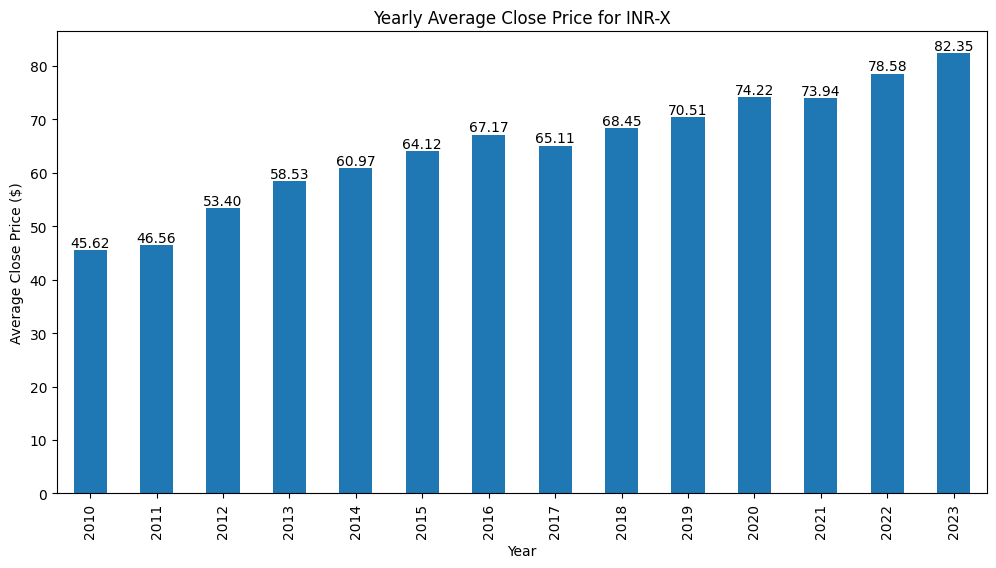

In [53]:
# Resample the DataFrame to yearly frequency and calculate the mean of the 'Close' price
avg_close_yearly = df[('Close', 'INR=X')].resample('Y').mean()

# Plot the yearly average close price
ax = avg_close_yearly.plot(kind='bar', figsize=(12, 6), title='Yearly Average Close Price for INR-X', ylabel='Average Close Price ($)', xlabel='Year')

# Annotate values on top of bars
for i, v in enumerate(avg_close_yearly.values):
    ax.text(i, v, f"{v:.2f}", ha='center', va='bottom')
avg_close_yearly.index = avg_close_yearly.index.year

# Plot the yearly average close price
avg_close_yearly.plot(kind='bar', figsize=(12, 6), title='Yearly Average Close Price for INR-X', ylabel='Average Close Price ($)', xlabel='Year',)

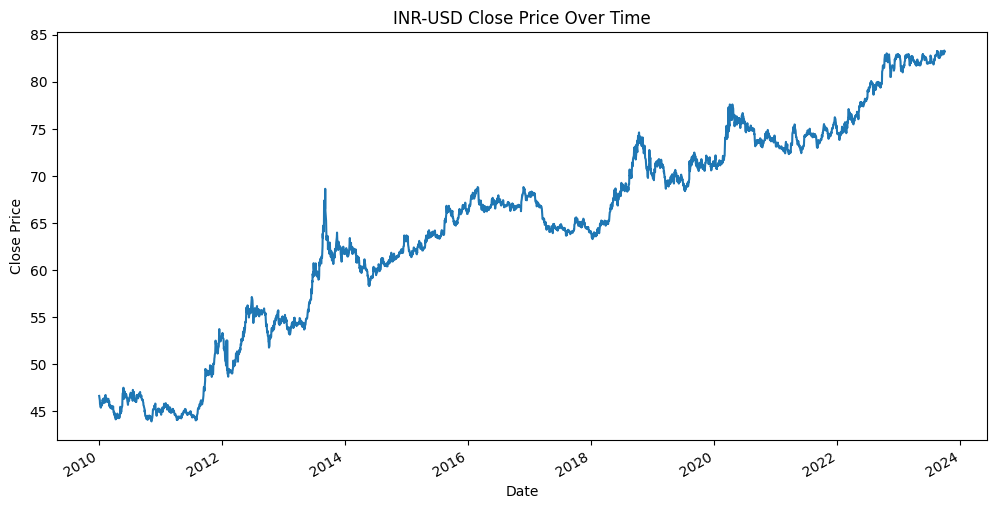

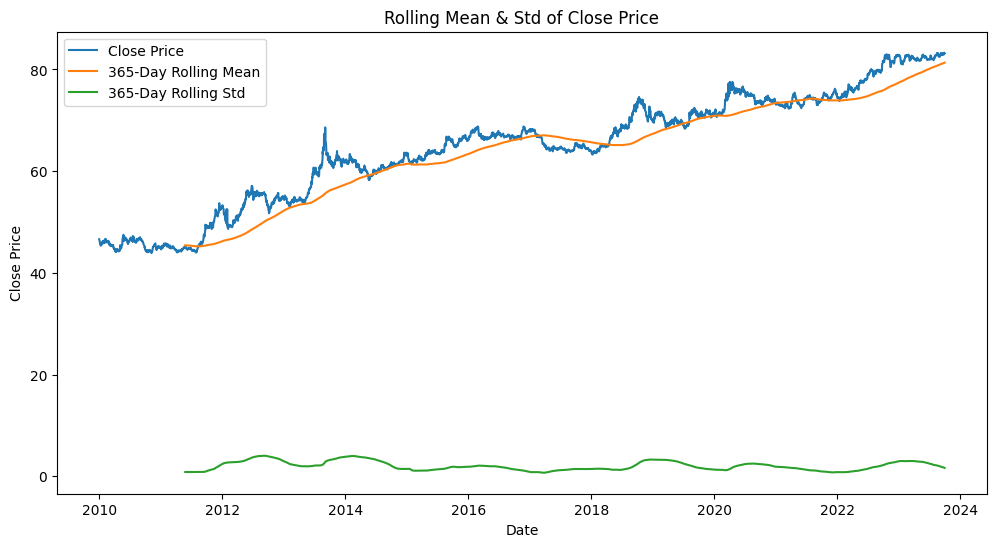

C:\Users\ansul\AppData\Local\Temp\ipykernel_11576\318083307.py:22: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_return = df[('Close', 'INR=X')].resample('Y').ffill().pct_change() * 100


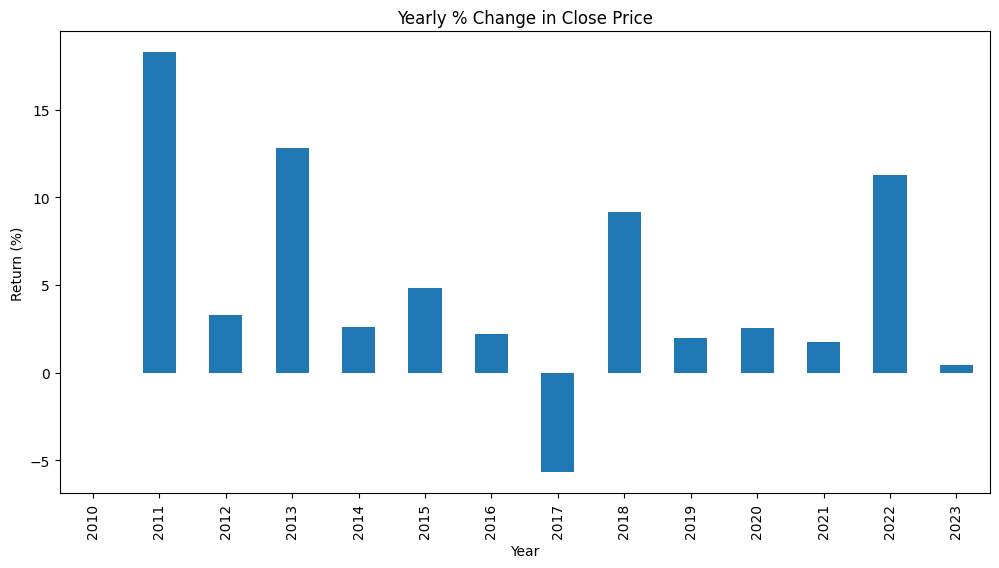

In [54]:
# Time Series EDA for INR-USD Forex Data

# Plot the Close price over time
df[('Close', 'INR=X')].plot(figsize=(12, 6), title='INR-USD Close Price Over Time', ylabel='Close Price', xlabel='Date')

# 2. Plot rolling mean and rolling std
window = 365  # 1 year window
rolling_mean = df[('Close', 'INR=X')].rolling(window=window).mean()
rolling_std = df[('Close', 'INR=X')].rolling(window=window).std()

plt.figure(figsize=(12, 6))
plt.plot(df[('Close', 'INR=X')], label='Close Price')
plt.plot(rolling_mean, label=f'{window}-Day Rolling Mean')
plt.plot(rolling_std, label=f'{window}-Day Rolling Std')
plt.title('Rolling Mean & Std of Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# 3. Plot yearly returns
yearly_return = df[('Close', 'INR=X')].resample('Y').ffill().pct_change() * 100
yearly_return.index = yearly_return.index.year
yearly_return.plot(kind='bar', figsize=(12, 6), title='Yearly % Change in Close Price', ylabel='Return (%)', xlabel='Year')
plt.show()



### Preparing Data for LSTM

In [55]:
df = df.reset_index()

In [56]:
## We will be predicting the Close price of INR-USD Forex dat
df_close = df[('Close', 'INR=X')].copy()

In [57]:
## Normalizing the close price data as LSTM are sesnsitive to the scale of input data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df_close=scaler.fit_transform(np.array(df_close).reshape(-1,1))
print(df_close)

[[0.06878398]
 [0.06061106]
 [0.05634698]
 ...
 [1.        ]
 [0.99807109]
 [0.99731723]]


In [58]:
##splitting data into training and testing set sequentially
training_size=int(len(df_close)*0.80)
test_size=len(df_close)-training_size
train_data,test_data=df_close[0:training_size,:],df_close[training_size:len(df_close),:1]

In [59]:
training_size,test_size

(2864, 717)

In [60]:
## Converting forex data into input suitable for LSTM
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [61]:
## Preparing trianing and testing data
X_train, y_train = create_dataset(train_data, time_step = 100)
X_test, y_test = create_dataset(test_data, time_step = 100)

In [62]:
print(f"X train shape: {X_train.shape} and y train shape: {y_train.shape}")
print(f"X test shape: {X_test.shape} and y train shape: {y_test.shape}")

X train shape: (2763, 100) and y train shape: (2763,)
X test shape: (616, 100) and y train shape: (616,)


In [63]:
## Converting input into 3D array as LSTM takes input in 3D format
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

### Preparing Base LSTM Model

In [64]:
# Building Vanilla LSTM Model
model=Sequential()
model.add(LSTM(50, input_shape=(100,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

## Building Stacked LSTM Model
model_stacked = Sequential()
model_stacked.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_stacked.add(LSTM(50, return_sequences=True))  
model_stacked.add(LSTM(50))
model_stacked.add(Dense(1))  
model_stacked.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\ansul\OneDrive\Desktop\data science project\Stock_Price_forecasting\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
model.summary(), model_stacked.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

(None, None)

In [66]:
import time
## Fitting the Vanilla LSTM Model
start_time = time.time()
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)
end_time = time.time()
print(f"Time taken to fit the model: {end_time - start_time:.2f} seconds")

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0952 - val_loss: 3.8959e-04
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0017 - val_loss: 2.7363e-04
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4.0908e-04 - val_loss: 3.0157e-04
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 3.0682e-04 - val_loss: 1.9448e-04
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3.1464e-04 - val_loss: 1.6678e-04
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.6848e-04 - val_loss: 1.6344e-04
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.7985e-04 - val_loss: 2.6022e-04
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.6979e-04 - val_loss: 2.2747e-04
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.6103e-04 - val_loss: 3.6522e-04
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.6254e-04 - val_loss: 2.4924e-04
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.6456

In [67]:
##fitting the stacked LSTM model
start_time_stacked = time.time()
model_stacked.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)
end_time_stacked = time.time()

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - loss: 0.0492 - val_loss: 0.0066
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 6.7171e-04 - val_loss: 0.0017
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 4.9964e-04 - val_loss: 9.0555e-04
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 5.2821e-04 - val_loss: 0.0011
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 4.6942e-04 - val_loss: 8.5746e-04
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 4.6255e-04 - val_loss: 3.6073e-04
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 4.5051e-04 - val_loss: 0.0011
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 4.1715e-04 - val_loss: 3.8265e-04
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 4.4678e-04 - val_loss: 4.7345e-04
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 3.9306e-04 - val_loss: 5.9543e-04
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 3.8381e

In [68]:
## Using model on test data and training data for vannila lstm
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

##using model on test data and training data for stacked lstm
train_predict_stacked = model_stacked.predict(X_train)  
test_predict_stacked = model_stacked.predict(X_test)

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [69]:
##Transformback to original form

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

train_predict_stacked = scaler.inverse_transform(train_predict_stacked)
test_predict_stacked = scaler.inverse_transform(test_predict_stacked)

In [70]:
### Calculating RMSE 
print("Training RMSE For Vanilla LSTM: ",math.sqrt(mean_squared_error(y_train,train_predict)))
print("Training RMSE For Stacked LSTM: ",math.sqrt(mean_squared_error(y_train,train_predict_stacked)))

Training RMSE For Vanilla LSTM:  62.10016432744549
Training RMSE For Stacked LSTM:  62.07732240276919


In [73]:
### Test Data RMSE
print("Test RMSE For Vanilla LSTM: ",math.sqrt(mean_squared_error(y_test,test_predict)))
print("Test RMSE For stacked LSTM: ",math.sqrt(mean_squared_error(y_test,test_predict_stacked)))

Test RMSE For Vanilla LSTM:  77.8362338287729
Test RMSE For stacked LSTM:  77.72441893423998


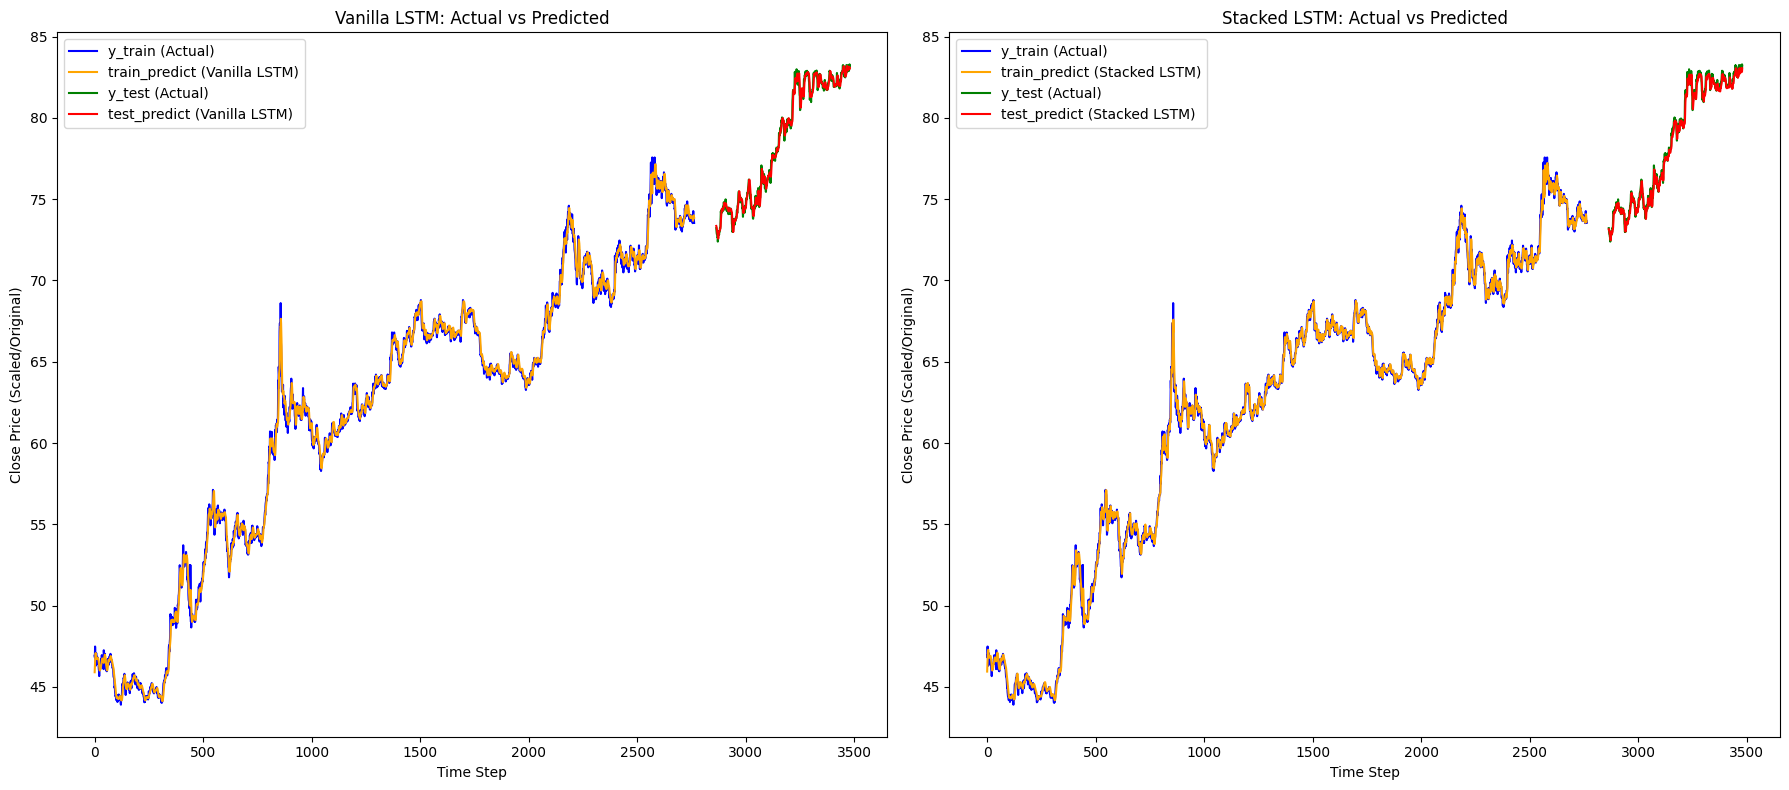

In [79]:
# Plotting predictions vs actuals for both Vanilla and Stacked LSTM


y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))

plt.figure(figsize=(18, 8))

# Plot for Vanilla LSTM
plt.subplot(1, 2, 1)
plt.plot(y_train, label='y_train (Actual)', color='blue')
plt.plot(train_predict, label='train_predict (Vanilla LSTM)', color='orange')
plt.plot(np.arange(training_size, training_size + len(y_test)), y_test, label='y_test (Actual)', color='green')
plt.plot(np.arange(training_size, training_size + len(test_predict)), test_predict, label='test_predict (Vanilla LSTM)', color='red')
plt.title('Vanilla LSTM: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Close Price (Scaled/Original)')
plt.legend()

# Plot for Stacked LSTM
plt.subplot(1, 2, 2)
plt.plot(y_train, label='y_train (Actual)', color='blue')
plt.plot(train_predict_stacked, label='train_predict (Stacked LSTM)', color='orange')
plt.plot(np.arange(training_size, training_size + len(y_test)), y_test, label='y_test (Actual)', color='green')
plt.plot(np.arange(training_size, training_size + len(test_predict_stacked)), test_predict_stacked, label='test_predict (Stacked LSTM)', color='red')
plt.title('Stacked LSTM: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Close Price (Scaled/Original)')
plt.legend()

plt.tight_layout()
plt.show()

## Sumamry
Both the models have very close rmse for both train and test dataset. However due to less number of parameters to train the vannila LSTM trains much faster than stacked LSTM.